In [58]:
import dlib
import cv2 as cv
import numpy as np
import matplotlib.pylab as plt
from skimage import data
from skimage.feature import Cascade
from skimage.io import imread
from skimage.transform import downscale_local_mean
from matplotlib import patches

import copy



In [126]:
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

path = "src/"

# The number of images in the set that produce the gallery
NUMBER_OF_SUBJECTS = 12
IMAGE_WIDTH = 1000
IMAGE_HEIGHT = 1000
loaded_gallery = []
THRESHOLDS = np.linspace(0.01,1.0,99)

# Making galery images, normalizing them, and then displaying them
for subject_num in range(0, NUMBER_OF_SUBJECTS):
    path = f'src/{subject_num}.jpg'
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.GaussianBlur(img, (15,15), 0)
    image_downscaled = cv.resize(img, (1000,1000), interpolation = cv.INTER_AREA)
    loaded_gallery.append(image_downscaled)

In [60]:
# Normalizing images
normalized_gallery = []
for i in range(NUMBER_OF_SUBJECTS):
    norm_img = np.zeros((1000, 1000))
    normalized_gallery.append(cv.normalize(loaded_gallery[i], norm_img, 0, 255, cv.NORM_MINMAX))

In [61]:
class Coordinate:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Rectangle:
    def __init__(self, top_left: Coordinate, bottom_right: Coordinate):
        self.top_left = top_left
        self.bottom_right = bottom_right


In [62]:
def print_images_w_rectangles(title: str, images: list, detections: list = [], rgb: tuple = (255,0,0)) -> list:
    """Prints images with detections, and can return each image with boxes

    Args:
        title(str): title of the figure
        images (list): list of images to draw rectangles onto
        detections (list): list of list of Rectangles to draw onto each image
        rgb (tuple): rgb values for the rectangles color
    
    Returns:
        list: a list images with boxes drawn
    """
    plt.figure(figsize=(15,15))
    return_images = []
    for i in range(len(images)):
        plt.subplot(4,3,i+1)
        temp_img = copy.deepcopy(images[i]) # So that we do not alter the original image
        if len(temp_img.shape) == 2:
            temp_img = cv.cvtColor(temp_img, cv.COLOR_GRAY2BGR)
        if len(detections) > 0:
            img_detections = detections[i]
            for rect in img_detections:
                cv.rectangle(temp_img, (rect.top_left.x, rect.top_left.y), (rect.bottom_right.x, rect.bottom_right.y ), rgb, 4)
        return_images.append(temp_img)
        plt.imshow(temp_img, cmap='gray')
    plt.suptitle(title)

    return return_images

In [63]:
# Using Haar cascade method return a  double array containing box coordinates of matches for each image
def haar_cascades(gallery: list, scale_factor: float, min_neighbors:int) -> list:
    """Using haar cascade method to detect faces

    Args:
        gallery (list): list of images to detect faces on
        scale_factor (float): specifies how the image is modified, the smaller the number the slower and more percise the detection
        min_neighbors (int): specifies how many neighbours to retain for each detection, high value means less detections but higher quality 

    Returns:
        list: a list of list containing Rectangles for each gallery image
    """
    haar_original = []
    for i in range(NUMBER_OF_SUBJECTS):
        temp_img = copy.deepcopy(gallery[i]) # So that we do not alter the original image
        faces = face_cascade.detectMultiScale(temp_img, scale_factor, min_neighbors)
        detections = []
        for (x,y,w,h) in faces:
            top_left = Coordinate(x, y)
            bottom_right = Coordinate(x+w, y+h)
            detections.append(Rectangle(top_left, bottom_right))
        haar_original.append(detections)    
    return haar_original


In [64]:
# LPB Based Haar Cascades and print it as well
def lpb_based_haar_cascades(gallery: list, scale_factor_p: float, step_ratio_p: int, min_size_p: int, max_size_p: int)-> list:
    """LPB based haar cascades

    Args:
        gallery (list): list of images to detect faces on
        scale_factor_p (float): specifcies how the image is modified, the smaller the number the slower and more percise the detection
        step_ratio_p (int): if equal to 1 all locations are searched, else some can be skipped
        min_size_p (int): minimum size for the window in which a face could be in
        max_size_p (int): maximum size for the window in which a face could be in

    Returns:
        list: a list of list containing Rectangles for each gallery image
    """
    lpb_based_haar_cascades_list = []
    # Load the trained file from the module root.
    trained_file = data.lbp_frontal_face_cascade_filename()

    # Initialize the detector cascade.
    detector = Cascade(trained_file)

    for i in range(NUMBER_OF_SUBJECTS):
        temp_img = copy.deepcopy(gallery[i]) # So that we do not alter the original image

        detected = detector.detect_multi_scale(img=temp_img,
                                            scale_factor=scale_factor_p,
                                            step_ratio=step_ratio_p,
                                            min_size=(min_size_p, min_size_p),
                                            max_size=(max_size_p, max_size_p))
        detections = []
        for patch in detected:
            top_left = Coordinate(patch['c'], patch['r'])
            bottom_right = Coordinate(patch['c']+patch['width'], patch['r'] + patch['height'])
            detections.append(Rectangle(top_left, bottom_right))
        lpb_based_haar_cascades_list.append(detections)

    return lpb_based_haar_cascades_list

In [65]:
def hog_svm_detection(gallery:list, upscale_factor: float, detection_threshold: float) -> list:
    """Face detection using hog svm

    Args:
        gallery (list): list of images to do face detection with
        upscale_factor (float): factor to upscale the image by
        detection_threshold (float): threshold for detection

    Returns:
        list: a list of lists containing detection Rectangles for each image
    """
    detector = dlib.get_frontal_face_detector()
    hog_svm = []
    
    for i in range(NUMBER_OF_SUBJECTS):
        img = copy.deepcopy(gallery[i])
        detected_faces, scores, idx = detector.run(img, upscale_factor, detection_threshold)
        detections = []
        for d in detected_faces:
            detections.append(Rectangle(Coordinate(d.left(), d.top()), Coordinate(d.right(), d.bottom())))
        hog_svm.append(detections)
    
    return hog_svm

    

In [66]:
def IoU(truth: Rectangle, observed: Rectangle, threshold: float, TP: int, FP: int):
    """Calculates the intersection over union, and returns the True Positive and False Positive \n
    amounts respectively incremented

    Args:
        truth (Rectangle): a rectangle around the truth
        observed (Rectangle): a rectange that was observed
        threshold (float): the threshold used to determine if it is a false positive or true positive
        TP (int): true positive amount
        FP (int): false positive amount

    Returns:
        _type_: (true positive, false positive) which are the respective args incremented
    """
    xA = max(truth.top_left.x, observed.top_left.x)
    yA = max(truth.top_left.y, observed.top_left.y)
    xB = min(truth.bottom_right.x, observed.bottom_right.x)
    yB = min(truth.bottom_right.y, observed.bottom_right.y)

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (truth.bottom_right.x - truth.top_left.x + 1) * (truth.bottom_right.y - truth.top_left.y + 1)
    boxBArea = (observed.bottom_right.x - observed.top_left.x + 1) * (observed.bottom_right.y - observed.top_left.y + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    if (iou>=threshold):
        TP += 1
    else:
        FP += 1

    return TP, FP

In [144]:
def score_gallery(truth_rect_list: list, observed_rect_list: list, threshold: float) -> tuple():
    """Scores a whole gallery returning the true positive, false positive, and false negative count\n
    False positive is defined as being less than the Intersection over Union amount\n
    True positive is defined as being greater than the Intersection over Union amount\n
    False negative is defind as the amount of times a face exists but no bounding boxes were found, or when\n
    a face exists and none of the bounding boxes create a true positive, (the face is missed, hence a false negative)

    Args:
        truth_rect_list (list): list of rectangles containing the "truth" rectangle for a face
        observed_rect_list (list): list of list of rectangles obtained from each algorithm
        threshold (float): threshold value to use for Intersection over Union

    Returns:
        tuple: (True Positive, False Positive, False Negative)
    """
    TP = 0
    FP = 0
    FN = 0
    for index, (truth_rect,observed_rect) in enumerate (zip(truth_rect_list, observed_rect_list)):
        if (len(truth_rect) > 0 and len(observed_rect) == 0):
            FN += 1
            continue
        local_tp_count = 0
        for detection_rect in observed_rect:
            if (len(truth_rect) > 0):
                local_tp_count, FP = IoU(truth_rect[0], detection_rect, threshold, local_tp_count, FP)
            else:
                FP += 1
        TP += local_tp_count
        if (local_tp_count == 0 and len(truth_rect) > 0 and len(observed_rect) > 0):
            FN += 1
        
    
    return TP, FP, FN

In [68]:
def Recall (TP: int, FN: int) -> float:
    """Given a True Positve and a False Neagtive calculates the Recall rate

    Args:
        TP (int): True positive
        FN (int): False negative

    Returns:
        float: the recall rate
    """
    if TP == 0 and FN == 0:
        return 0
    else:
        return TP/(TP+FN)

def Percision(TP: int, FP:int) -> float:
    """Given a True Positive and a False Positive calculates the Percision rate

    Args:
        TP (int): True positive
        FP (int): False positive

    Returns:
        float: percision rate
    """
    if TP == 0 and FP == 0:
        return 0
    else:
        return TP/(TP+FP)

In [69]:
# Generating ground truth see notes  on how this was obtained
ground_truth = []
image_zero = []
image_zero.append(Rectangle(Coordinate(451, 163), Coordinate(520, 217)))
image_one = []
image_one.append(Rectangle(Coordinate(332, 315), Coordinate(651, 542)))
image_two = []
image_two.append(Rectangle(Coordinate(298, 422), Coordinate(642, 618)))
image_three = []
image_three.append(Rectangle(Coordinate(348, 305), Coordinate(515, 554)))
image_four = []
image_four.append(Rectangle(Coordinate(368, 239), Coordinate(646, 419)))
image_five = []
image_five.append(Rectangle(Coordinate(243, 376), Coordinate(662, 701)))
image_six = []
image_six.append(Rectangle(Coordinate(326, 303), Coordinate(562, 472)))
image_seven = []
image_seven.append(Rectangle(Coordinate(465, 235), Coordinate(644, 558)))
image_eight = []
image_eight.append(Rectangle(Coordinate(499, 236), Coordinate(636, 337)))
image_nine = []
image_ten = []
image_eleven = []
ground_truth.append(image_zero)
ground_truth.append(image_one)
ground_truth.append(image_two)
ground_truth.append(image_three)
ground_truth.append(image_four)
ground_truth.append(image_five)
ground_truth.append(image_six)
ground_truth.append(image_seven)
ground_truth.append(image_eight)
ground_truth.append(image_nine)
ground_truth.append(image_ten)
ground_truth.append(image_eleven)

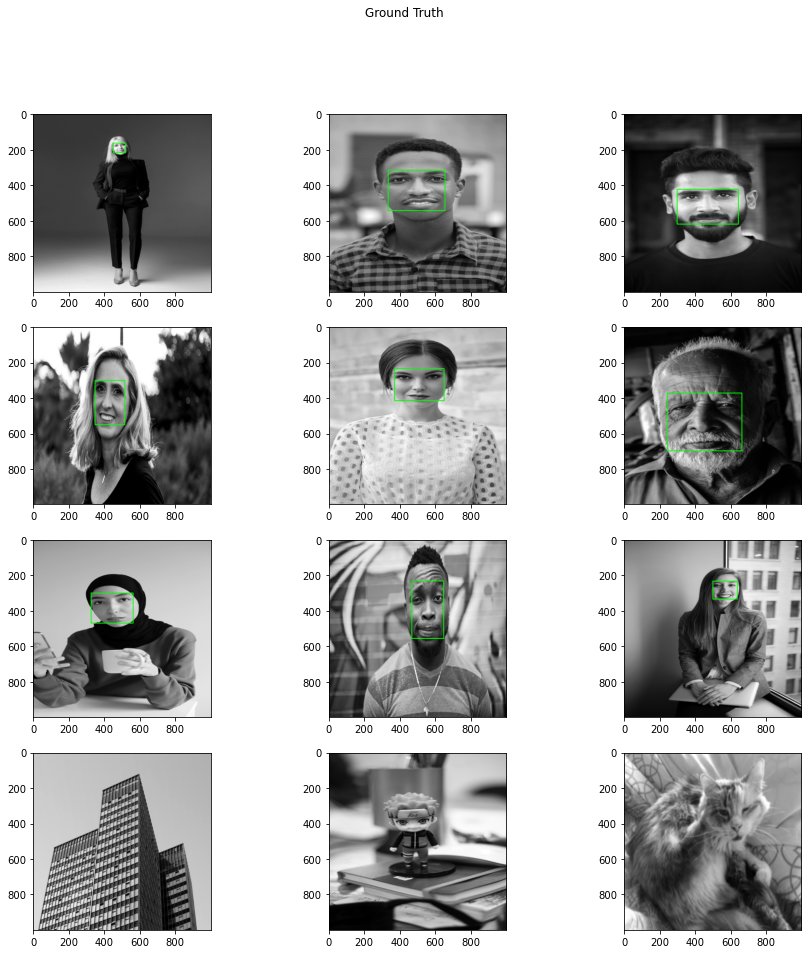

In [70]:
ground_images = print_images_w_rectangles("Ground Truth", normalized_gallery, ground_truth, (0,255,0))

In [165]:
threshold = 0.25
print("Changing scale_factor")
for scale_factor in [1.05, 1.1, 1.4]:
    min_neighbour = 4
    haar_cascade = haar_cascades(normalized_gallery, scale_factor, min_neighbour)
    TP, FP, FN = score_gallery(ground_truth, haar_cascade, threshold)
    title_string = f'For threshold: {threshold} Scale Factor: {scale_factor} Min Neighbour: {min_neighbour} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    print(title_string)

print("Changing min_neighbour")
for min_neighbour  in [2 ,4 ,6]:
        scale_factor = 1.1
        haar_cascade = haar_cascades(normalized_gallery, scale_factor, min_neighbour)
        TP, FP, FN = score_gallery(ground_truth, haar_cascade, threshold)
        title_string = f'For threshold: {threshold} Scale Factor: {scale_factor} Min Neighbour: {min_neighbour} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
        print(title_string)


Changing scale_factor
For threshold: 0.25 Scale Factor: 1.05 Min Neighbour: 4 TP: 10 FP: 19 FN: 0 Percision: 0.3448 Recall: 1.0000
For threshold: 0.25 Scale Factor: 1.1 Min Neighbour: 4 TP: 9 FP: 7 FN: 0 Percision: 0.5625 Recall: 1.0000
For threshold: 0.25 Scale Factor: 1.4 Min Neighbour: 4 TP: 6 FP: 0 FN: 4 Percision: 1.0000 Recall: 0.6000
Changing min_neighbour
For threshold: 0.25 Scale Factor: 1.1 Min Neighbour: 2 TP: 11 FP: 15 FN: 0 Percision: 0.4231 Recall: 1.0000
For threshold: 0.25 Scale Factor: 1.1 Min Neighbour: 4 TP: 9 FP: 7 FN: 0 Percision: 0.5625 Recall: 1.0000
For threshold: 0.25 Scale Factor: 1.1 Min Neighbour: 6 TP: 8 FP: 6 FN: 1 Percision: 0.5714 Recall: 0.8889


For threshold: 0.25 Scale Factor: 1.1 Min Neighbour: 4 TP: 9 FP: 7 FN: 0 Percision: 0.5625 Recall: 1.0000


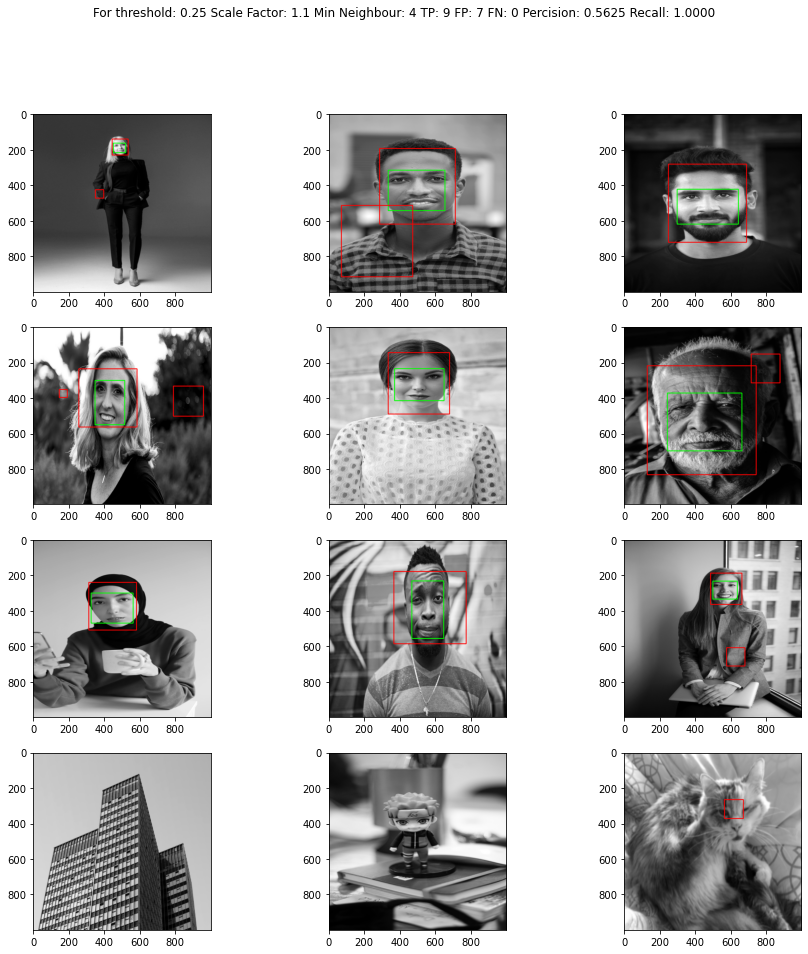

In [166]:
# Best haar cascade
scale_factor = 1.1
min_neighbour = 4 
threshold = 0.25
haar_cascade = haar_cascades(normalized_gallery, scale_factor, min_neighbour)
TP, FP, FN = score_gallery(ground_truth, haar_cascade, threshold)
title_string = f'For threshold: {threshold} Scale Factor: {scale_factor} Min Neighbour: {min_neighbour} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
print_images_w_rectangles(title_string, ground_images, haar_cascade, (255,0,0))
print(title_string)

In [162]:
threshold = 0.25
print("Changing scale_factor")
for scale_factor in [1.05, 1.2, 1.4]:
    step_ratio = 1
    min_size = 60
    max_size = 750
    lpb_based_haar_cascade = lpb_based_haar_cascades(normalized_gallery, scale_factor, step_ratio, min_size, max_size)
    TP, FP, FN = score_gallery(ground_truth, lpb_based_haar_cascade, threshold)
    title_string = f'For threshold: {threshold} Scale Factor: {scale_factor} step_ratio: {step_ratio} min_size : {min_size} max_size {max_size} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    print(title_string)
print("Changing step_ratio")
for step_ratio  in [1 ,2 ,3]:
    scale_factor = 1.2
    min_size = 60
    max_size = 750
    lpb_based_haar_cascade = lpb_based_haar_cascades(normalized_gallery, scale_factor, step_ratio, min_size, max_size)
    TP, FP, FN = score_gallery(ground_truth, lpb_based_haar_cascade, threshold)
    title_string = f'For threshold: {threshold} Scale Factor: {scale_factor} step_ratio: {step_ratio} min_size : {min_size} max_size {max_size} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    print(title_string)
print("Changing min_size")
for min_size  in [10 ,60 ,200]:
    step_ratio = 1
    scale_factor = 1.2
    max_size = 750
    lpb_based_haar_cascade = lpb_based_haar_cascades(normalized_gallery, scale_factor, step_ratio, min_size, max_size)
    TP, FP, FN = score_gallery(ground_truth, lpb_based_haar_cascade, threshold)
    title_string = f'For threshold: {threshold} Scale Factor: {scale_factor} step_ratio: {step_ratio} min_size : {min_size} max_size {max_size} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    print(title_string)
print("Changing max_size")
for max_size in [105, 500, 750]:
    step_ratio = 1
    scale_factor = 1.2
    min_size = 60
    lpb_based_haar_cascade = lpb_based_haar_cascades(normalized_gallery, scale_factor, step_ratio, min_size, max_size)
    TP, FP, FN = score_gallery(ground_truth, lpb_based_haar_cascade, threshold)
    title_string = f'For threshold: {threshold} Scale Factor: {scale_factor} step_ratio: {step_ratio} min_size : {min_size} max_size {max_size} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    print(title_string)

Changing scale_factor
For threshold: 0.25 Scale Factor: 1.05 step_ratio: 1 min_size : 60 max_size 750 TP: 14 FP: 23 FN: 1 Percision: 0.3784 Recall: 0.9333
For threshold: 0.25 Scale Factor: 1.2 step_ratio: 1 min_size : 60 max_size 750 TP: 8 FP: 2 FN: 1 Percision: 0.8000 Recall: 0.8889
For threshold: 0.25 Scale Factor: 1.4 step_ratio: 1 min_size : 60 max_size 750 TP: 7 FP: 1 FN: 2 Percision: 0.8750 Recall: 0.7778
Changing step_ratio
For threshold: 0.25 Scale Factor: 1.2 step_ratio: 1 min_size : 60 max_size 750 TP: 8 FP: 2 FN: 1 Percision: 0.8000 Recall: 0.8889
For threshold: 0.25 Scale Factor: 1.2 step_ratio: 2 min_size : 60 max_size 750 TP: 2 FP: 0 FN: 7 Percision: 1.0000 Recall: 0.2222
For threshold: 0.25 Scale Factor: 1.2 step_ratio: 3 min_size : 60 max_size 750 TP: 0 FP: 0 FN: 9 Percision: 0.0000 Recall: 0.0000
Changing min_size
For threshold: 0.25 Scale Factor: 1.2 step_ratio: 1 min_size : 10 max_size 750 TP: 8 FP: 10 FN: 1 Percision: 0.4444 Recall: 0.8889
For threshold: 0.25 Scale 

For threshold: 0.25 Scale Factor: 1.2 step_ratio: 1 min_size : 60 max_size 500 TP: 8 FP: 2 FN: 1 Percision: 0.8000 Recall: 0.8889


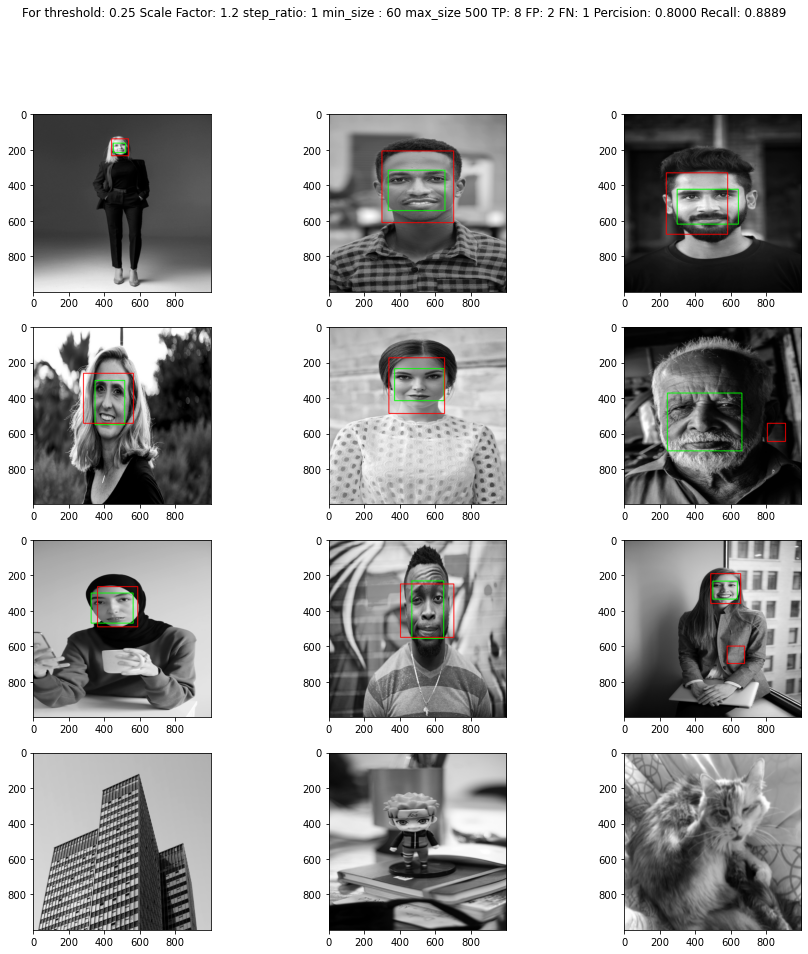

In [163]:
# Best performing LPB Haar Cascade
threshold = 0.25
scale_factor = 1.2
step_ratio = 1
min_size = 60
max_size = 500
lpb_based_haar_cascade = lpb_based_haar_cascades(normalized_gallery, scale_factor, step_ratio, min_size, max_size)
TP, FP, FN = score_gallery(ground_truth, lpb_based_haar_cascade, threshold)
title_string = f'For threshold: {threshold} Scale Factor: {scale_factor} step_ratio: {step_ratio} min_size : {min_size} max_size {max_size} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
print_images_w_rectangles(title_string, ground_images, lpb_based_haar_cascade, (255,0,0))
print(title_string)

In [168]:
upscale_factors = [1,2,3,4]
for upscale_factor in upscale_factors:
    hog_svm = hog_svm_detection(normalized_gallery, upscale_factor, 0)
    TP, FP, FN = score_gallery(ground_truth, hog_svm, 0.25)
    title_string = f'For upscale factor: {upscale_factor} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    print(title_string)


For upscale factor: 1 TP: 7 FP: 0 FN: 2 Percision: 1.0000 Recall: 0.7778
For upscale factor: 2 TP: 8 FP: 0 FN: 1 Percision: 1.0000 Recall: 0.8889
For upscale factor: 3 TP: 8 FP: 0 FN: 1 Percision: 1.0000 Recall: 0.8889
For upscale factor: 4 TP: 7 FP: 0 FN: 2 Percision: 1.0000 Recall: 0.7778


In [172]:
hog_svm_thresholds = [0,0.01,0.05,0.1]
upscale_factor = 2
for hog_svm_threshold in hog_svm_thresholds:
    hog_svm = hog_svm_detection(normalized_gallery, upscale_factor, hog_svm_threshold)
    TP, FP, FN = score_gallery(ground_truth, hog_svm, 0.25)
    title_string = f'For hog svm threshold: {hog_svm_threshold} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    print(title_string)

For hog svm threshold: 0 TP: 8 FP: 0 FN: 1 Percision: 1.0000 Recall: 0.8889
For hog svm threshold: 0.01 TP: 8 FP: 0 FN: 1 Percision: 1.0000 Recall: 0.8889
For hog svm threshold: 0.05 TP: 7 FP: 0 FN: 2 Percision: 1.0000 Recall: 0.7778
For hog svm threshold: 0.1 TP: 5 FP: 0 FN: 4 Percision: 1.0000 Recall: 0.5556


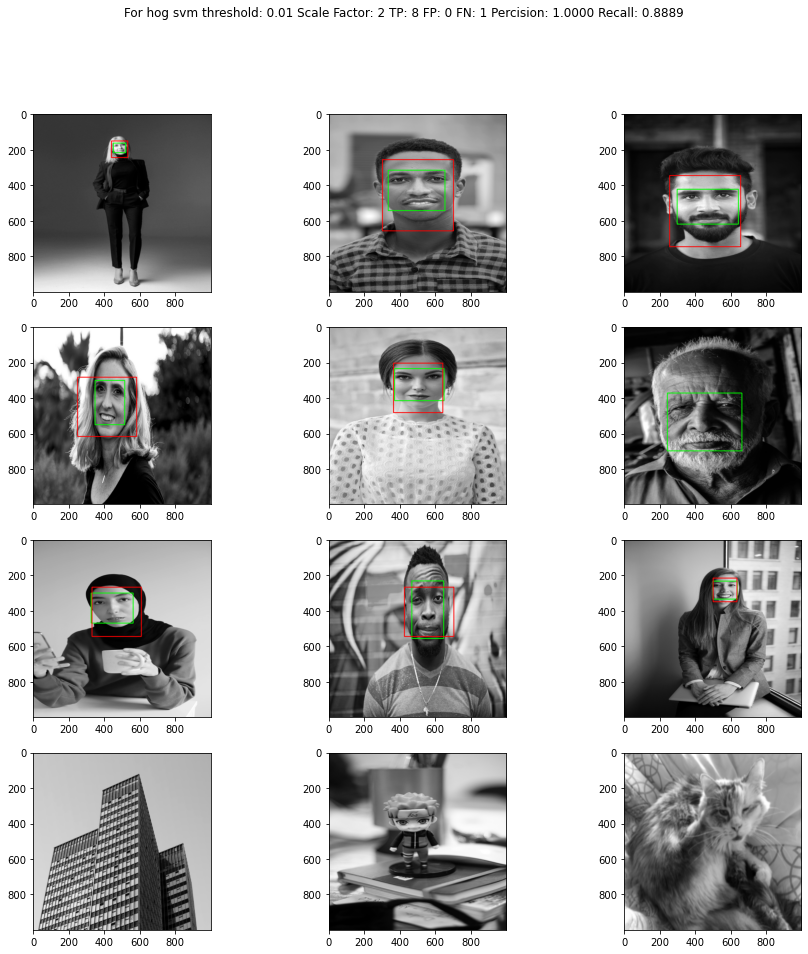

In [174]:
# Best performing HOG SVM
upscale_factor = 2
hog_svm = hog_svm_detection(normalized_gallery, upscale_factor, 0.01)
TP, FP, FN = score_gallery(ground_truth, hog_svm, 0.25)
title_string = f'For hog svm threshold: {0.01} Up Scale Factor: {upscale_factor} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
print_images_w_rectangles(title_string, ground_images, hog_svm, (255,0,0));

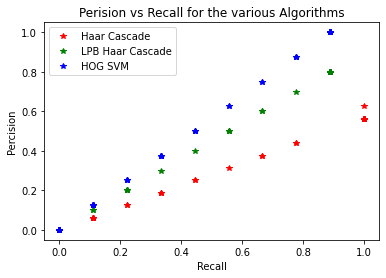

In [167]:
haar_cascade_threshold_percision = []
haar_cascade_threshold_recall = []
scale_factor = 1.1
min_neighbour = 4
haar_cascade = haar_cascades(normalized_gallery, scale_factor, min_neighbour)
for threshold in THRESHOLDS:
    TP, FP, FN = score_gallery(ground_truth, haar_cascade, threshold)
    title_string = f'For threshold: {threshold:.2f} Scale Factor: {scale_factor} Min Neighbour: {min_neighbour} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    haar_cascade_threshold_percision.append(Percision(TP,FP))
    haar_cascade_threshold_recall.append(Recall(TP, FN))
    
lpb_haar_cascade_threshold_percision = []
lpb_haar_cascade_threshold_recall = []
scale_factor = 1.2
step_ratio = 1
min_size = 60
max_size = 500
lpb_based_haar_cascade = lpb_based_haar_cascades(normalized_gallery, scale_factor, step_ratio, min_size, max_size)
for threshold in THRESHOLDS:
    TP, FP, FN = score_gallery(ground_truth, lpb_based_haar_cascade, threshold)
    title_string = f'For threshold: {threshold:.2f} Scale Factor: {scale_factor} step_ratio: {step_ratio} min_size : {min_size} max_size {max_size} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    lpb_haar_cascade_threshold_percision.append(Percision(TP,FP))
    lpb_haar_cascade_threshold_recall.append(Recall(TP, FN))

hog_svm_threshold_percision = []
hog_svm_threshold_recall = []

upscale_factor = 2
hog_svm = hog_svm_detection(normalized_gallery, upscale_factor, 0)
for threshold in THRESHOLDS:
    TP, FP, FN = score_gallery(ground_truth, hog_svm, threshold)
    title_string = f'For threshold: {threshold:.2f} TP: {TP} FP: {FP} FN: {FN} Percision: {Percision(TP,FP):.4f} Recall: {Recall(TP, FN):.4f}'
    hog_svm_threshold_percision.append(Percision(TP,FP))
    hog_svm_threshold_recall.append(Recall(TP, FN))

plt.plot(haar_cascade_threshold_recall, haar_cascade_threshold_percision, 'r*',lpb_haar_cascade_threshold_recall, lpb_haar_cascade_threshold_percision, 'g*', hog_svm_threshold_recall,hog_svm_threshold_percision, 'b*')
plt.xlabel("Recall")
plt.ylabel("Percision")
plt.legend(["Haar Cascade", "LPB Haar Cascade", "HOG SVM"])
plt.title("Perision vs Recall for the various Algorithms")
plt.show()